The code in this Jupyter notebook produces the supplemental figures in "Drivers of Physical and Economic Impacts of Water Scarcity in Latin America and the Caribbean."

Please contact Abigail Birnbaum at abigail.birnbaum@tufts.edu with any questions.

# Import Statements

In [1]:
# These are the packages required for this code. 
# Make sure that they're installed in your Python 3 environment
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore') #for not printing warnings
import numpy as np
import matplotlib.colors as mcolors

In [2]:
# this is the path to where all the data is stored to produce these figures
# make sure it is correct for your machine
fpath = '/cluster/tufts/lamontagnelab/abirnb01/LACwaterscarcity/data/query_results/'

# Figure S1. Map of LAC basins

Supplemental Figure 1 was made using ArcGIS Pro. The shapefile for Latin America and Caribbean GCAM water basins can be found at 
LACwaterscarcity/data/map_shapefiles/LAC_basins/lac_basins.shp

The shapefiles were originally downloaded from: https://zenodo.org/record/4014308#.YhekfOjMKUk

 # Figure S2. Runoff for different ESMs

Plot runoff for the different ESMs under restricted reservoir storage assumptions

In [3]:
lac_runoff = pd.read_pickle('/cluster/tufts/lamontagnelab/abirnb01/LACwaterscarcity/data/query_results/LAC_runoff')

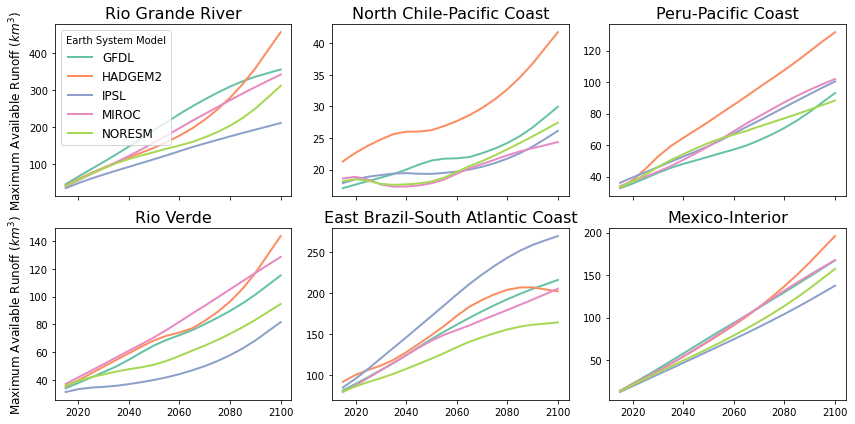

In [32]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(12,6),sharex=True)
axes = [ax1,ax2,ax3,ax4,ax5,ax6]

basins = ['Rio Grande River','North Chile-Pacific Coast','Peru-Pacific Coast',
          'Rio Verde','East Brazil-South Atlantic Coast','Mexico-Interior']

for i in range(len(axes)):
    b = basins[i]
    sns.lineplot(ax=axes[i],data=lac_runoff[(lac_runoff.basin==b) & (lac_runoff.res=='exp')],x='year',y='value',hue='esm',
                palette='Set2',hue_order=['gfdl','hadgem','ipsl','miroc','noresm'],lw=2,legend=False)
    axes[i].set_title(b,size=16)
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    if (i==0) or (i==3):
        if i== 0:
            axes[i].legend(loc='upper left',title='Earth System Model',labels=['GFDL','HADGEM2','IPSL','MIROC','NORESM'],fontsize=12)
        axes[i].set_ylabel('Maximum Available Runoff ($km^3$)',fontsize=12)
plt.tight_layout()
plt.show()


# Figure S3. Global UCT vs FFICT crop production and Mexico region net exports

In [46]:
#global land allocated to crops
lalloc_glob = pd.read_pickle(fpath+'land_crop') #global ag production
lalloc_glob_tax = lalloc_glob[(lalloc_glob.ssp==2)&(lalloc_glob.ag==5)&(lalloc_glob.gw==1)&(lalloc_glob.res==1)&
                         (lalloc_glob.esm==2) & (lalloc_glob.soc==3)]
lalloc_glob_tax = lalloc_glob_tax[lalloc_glob_tax.landleaf.isin(['Corn','FiberCrop','FodderGrass',
                                                                'FodderHerb','MiscCrop','OilCrop',
                                                                'OtherGrain','PalmFruit','Rice',
                                                                'Root_Tuber','SugarCrop','Wheat'])]
lalloc_glob_tax = lalloc_glob_tax.groupby(['Units','year','gw','res','esm','tax','ssp','ag','soc'])['value'].sum()
lalloc_glob_tax = lalloc_glob_tax.reset_index()

In [51]:
#crop production in Mexico

#read in crop consumption and production datasets for this basin
#already limited to scenarios of interest: ssp_ag5_soc3_gwlo_rs_hadgem_NDC_Tax_uct and ssp_ag5_soc3_gwlo_rs_hadgem_NDC_Tax_ffict
# already removed non MT crops and pasture
crop_csmp = pd.read_pickle('/cluster/tufts/lamontagnelab/abirnb01/LACwaterscarcity/data/query_results/crop_csmp_mxc_tax')
crop_prod = pd.read_pickle('/cluster/tufts/lamontagnelab/abirnb01/LACwaterscarcity/data/query_results/crop_prod_mxc_tax')

#sum up consumption across crops
crop_csmp_sum = crop_csmp.groupby(['scenario','year','Units','tax'])['value'].sum()
crop_csmp_sum = crop_csmp_sum.reset_index()

#sum up production across crops
crop_prod_sum = crop_prod.groupby(['scenario','year','Units','tax'])['value'].sum()
crop_prod_sum = crop_prod_sum.reset_index()

#merge production and consumption dataframes
crop_merge = crop_csmp_sum.merge(crop_prod_sum,on=['scenario','year','Units','tax'],
                                suffixes=['_csmp','_prod'])

#calculate production - consumption (net exports in MT)
crop_merge['value_diff'] = crop_merge['value_prod'] - crop_merge['value_csmp']



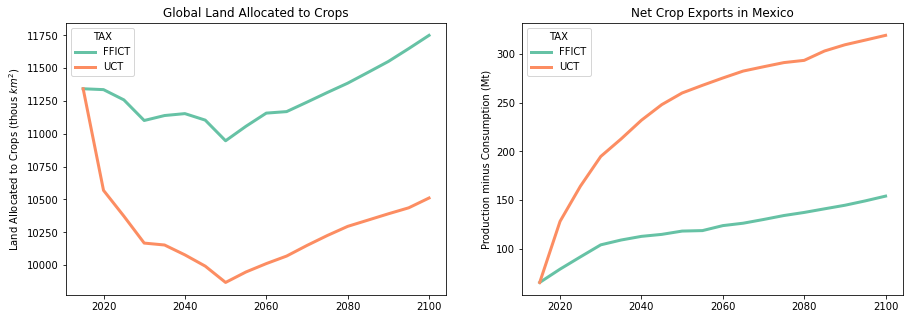

In [53]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(ax=ax1,data=lalloc_glob_tax,x='year',y='value',hue='tax',palette='Set2', lw=3)
ax1.set_xlabel('')
ax1.set_ylabel('Land Allocated to Crops (thous $km^2$)')
ax1.set_title('Global Land Allocated to Crops')
ax1.legend(title='TAX',labels=['FFICT','UCT'])

sns.lineplot(ax=ax2,data=crop_merge,x='year',y='value_diff',hue='tax',palette='Set2',lw=3)
ax2.set_xlabel('')
ax2.set_ylabel('Production minus Consumption (Mt)')
ax2.legend(title='TAX',labels=['FFICT','UCT'])
ax2.set_title('Net Crop Exports in Mexico')

plt.show()




# Figure S4. North Chile-Pacific Coast Crop Production (by SOC)

In [5]:
#load in ag production dataset
agprod_ncpc = pd.read_pickle(fpath+'ag_production_ncpc') #ag production in North Chile-Pacific Coast basin

In [6]:
#ag production in NCPC: sum across technologies
agprod_ncpc = agprod_ncpc.groupby(['Units','sector','output','year','gw','res','esm','tax','ssp','ag','soc'])['value'].sum()
agprod_ncpc = agprod_ncpc.reset_index()

In [7]:
#get ag production for five scenarios that share all parameter assumptions except SOC
agprod_soc = agprod_ncpc[(agprod_ncpc.ssp==2)& #from ag
                        (agprod_ncpc.ag==5)& #ag = SSP5
                         (agprod_ncpc.tax==2)& #tax = UCT
                         (agprod_ncpc.esm==1)& #esm = GFDL
                         (agprod_ncpc.gw==1)& #gw = low
                         (agprod_ncpc.res==1)] #res = restricted

In [8]:
#sum up across sectors - exclude biomass, forest, and pasture
agprod_soc_sum = agprod_soc[~(agprod_soc['sector'].isin(['biomass','Pasture','Forest']))]
agprod_soc_sum = agprod_soc_sum.groupby(['Units','year','soc'])['value'].sum()
agprod_soc_sum = agprod_soc_sum.reset_index()

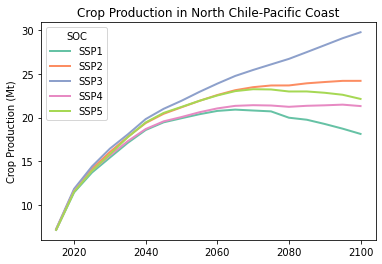

In [9]:
sns.lineplot(data=agprod_soc_sum,x='year',y='value',hue='soc',lw=2,palette='Set2')
plt.xlabel('')
plt.ylabel('Crop Production ('+agprod_soc_sum['Units'].iloc[0]+')')
plt.title('Crop Production in North Chile-Pacific Coast')
plt.legend(title='SOC',labels=['SSP1','SSP2','SSP3','SSP4','SSP5'])
plt.show()

# Figure S5. North Chile-Pacific Coast Crop Efficiency

In [10]:
#load in data
agprod_glob = pd.read_pickle(fpath+'glob_ag_prod') #global ag production
#agprod_ncpc is already loaded for supplemental figure 3
lalloc_glob = pd.read_pickle(fpath+'land_crop') #global land allocation
lalloc_ncpc = pd.read_pickle(fpath+'land_alloc_ncpc') #land allocation in North Chile-Pacific Coast basin

In [11]:
#simplify North Chile-Pacific Coast (NCPC) land allocation

#sum across regions
lalloc_ncpc = lalloc_ncpc.groupby(['Units','scenario','landleaf','year','gw','res','esm','tax','ssp','ag','soc'])['value'].sum()
lalloc_ncpc = lalloc_ncpc.reset_index()

#split up landleaf
lalloc_ncpc[['crop','basin','wtype','wlevel']] = lalloc_ncpc['landleaf'].str.rsplit('_',n=3,expand=True)

#sum across wtype/wlevel
lalloc_ncpc = lalloc_ncpc.groupby(['Units','scenario','year','gw','ssp','res','esm','tax','soc','ag','crop','basin'])['value'].sum()
lalloc_ncpc = lalloc_ncpc.reset_index()
lalloc_ncpc = lalloc_ncpc.rename(columns={'crop':'sector','value':'lalloc_basin'})

#merge landleaf for ncpc with global landleaf
lalloc_glob = lalloc_glob.rename(columns={'landleaf':'sector','value':'lalloc_glob'}) #rename global landleaf

#merge
lalloc_merge = lalloc_glob.merge(lalloc_ncpc,on=['Units','scenario','sector','year','gw',
                                          'res','esm','soc','ag','tax','gw','ssp'],suffixes=['_glob','_basin'])

#ag production in NCPC: sum across technologies - done above for supplemental figure 3
#agprod_ncpc = agprod_ncpc.groupby(['Units','sector','output','year','gw','res','esm','tax','ssp','ag','soc'])['value'].sum()
#agprod_ncpc = agprod_ncpc.reset_index()

#merge NCPC basin and global ag production
agprod_merge = agprod_glob.merge(agprod_ncpc,on=['Units','sector','output','year','gw','res','esm',
                                                'tax','ssp','ag','soc'],suffixes=['_glob','_basin'])

#now merge land allocation with ag production
lalloc_agprod = lalloc_merge.merge(agprod_merge,on=['sector','year','gw','res','esm','tax','ssp',
                                                   'ag','soc'],suffixes=['_lalloc','_agprod'])

#now limit to just crops with highest production in NCPC (MiscCrop and FodderHerb)
lalloc_agprod_lim = lalloc_agprod[lalloc_agprod.sector.isin(['MiscCrop','FodderHerb'])]

#let's calculate efficiency --> production/land allocation
lalloc_agprod_lim['crop_efficiency_basin'] = lalloc_agprod_lim['value_basin']/lalloc_agprod_lim['lalloc_basin']
lalloc_agprod_lim['crop_efficiency_glob'] = lalloc_agprod_lim['value_glob']/lalloc_agprod_lim['lalloc_glob']

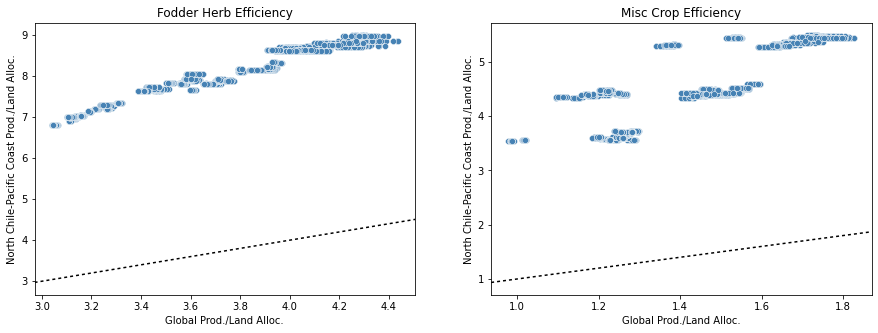

In [12]:
#now plot crop efficiency in 2100 for these two crops
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
sns.scatterplot(data=lalloc_agprod_lim[(lalloc_agprod_lim['sector']=='FodderHerb') & (lalloc_agprod_lim['year']==2100)],
               x='crop_efficiency_glob',y='crop_efficiency_basin',ax=ax1,color='steelblue')
sns.scatterplot(data=lalloc_agprod_lim[(lalloc_agprod_lim['sector']=='MiscCrop') & (lalloc_agprod_lim['year']==2100)],
               x='crop_efficiency_glob',y='crop_efficiency_basin',ax=ax2,color='steelblue')

#plot 1:1 lines
xmin,xmax = ax1.get_xlim()
oneone = np.linspace(xmin,xmax,100)
sns.lineplot(oneone,oneone,color='k',style=True, dashes=[(2,2)],ax=ax1,legend=None)    
ax1.set_xlim([xmin,xmax])
xmin,xmax = ax2.get_xlim()
oneone = np.linspace(xmin,xmax,100)
sns.lineplot(oneone,oneone,color='k',style=True, dashes=[(2,2)],ax=ax2,legend=None)    
ax2.set_xlim([xmin,xmax])

#titles and labels
ax1.set_title('Fodder Herb Efficiency')
ax1.set_ylabel('North Chile-Pacific Coast Prod./Land Alloc.')
ax1.set_xlabel('Global Prod./Land Alloc.')
ax2.set_title('Misc Crop Efficiency')
ax2.set_ylabel('North Chile-Pacific Coast Prod./Land Alloc.')
ax2.set_xlabel('Global Prod./Land Alloc.')
plt.show()

# Figure S6. North Chile-Pacific Coast Land Allocation in 2100

In [13]:
def land_type(df):
    """ Function to categorize each land allocation into land types"""
    #split up land into different categories
    crops = ['Corn','FiberCrop','FodderGrass','FodderHerb',
            'MiscCrop', 'OilCrop','OtherGrain','Rice','Root_Tuber',
            'SugarCrop','Wheat','PalmFruit']
    bmass =  ['biomass_grass','biomass_tree']
    protected_land =  ['ProtectedGrassland','ProtectedShrubland',
            'ProtectedUnmanagedPasture','ProtectedUnmanagedForest']
    forest = ['Forest','UnmanagedForest']
    nonarable = ['Tundra','RockIceDesert','UrbanLand']
    grassshrub =  ['Grassland','Shrubland']
    pasture = ['Pasture','UnmanagedPasture']
    otherarable = ['OtherArableLand']

    landtype_list = [crops,bmass,protected_land,forest,nonarable,grassshrub,pasture,otherarable]
    landtype_list_name = ['Crops','Biomass','Protected Land','Forest (not protected)','Non-Arable Land',
                         'Grassland/Shrubland','Pasture','Other Arable Land']

    #categorize each land use by type
    df['land_type'] = ''
    for i in range(len(landtype_list[:])):
        df.loc[df['sector'].isin(landtype_list[i]),'land_type'] = landtype_list_name[i]
    return df

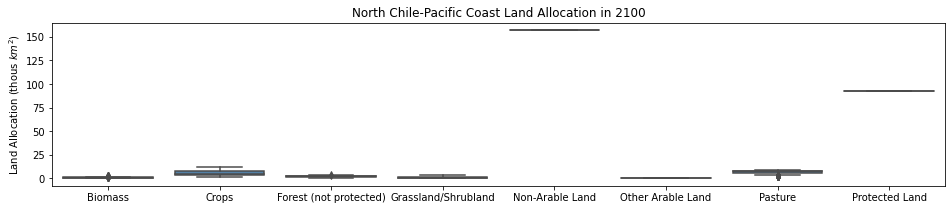

In [30]:
#PLOT BOXPLOT OF LAND ALLOCATION IN 2100
lalloc_ncpc_sum = land_type(lalloc_ncpc)
lalloc_ncpc_sum = lalloc_ncpc_sum.groupby(['Units','scenario','year','gw','ssp','res','esm',
                                         'tax','soc','ag','land_type'])['lalloc_basin'].sum()
lalloc_ncpc_sum = lalloc_ncpc_sum.reset_index()

fig = plt.figure(figsize=(16,3))
sns.boxplot(data=lalloc_ncpc_sum[lalloc_ncpc_sum.year==2100],y='lalloc_basin',x='land_type',color='steelblue')
plt.xlabel('')
plt.ylabel('Land Allocation (thous $km^2$)')
plt.title('North Chile-Pacific Coast Land Allocation in 2100')
plt.show()

# Figure S7. Peru Pacific Coast Land Allocation (by TAX)

In [15]:
#stacked barplot overtime

def plot_landchange(df,plt_title):

    """Plot of land allocation for basin in scenarios - add more to this description
    Inputs:
    df = dataframe with land allocation for given water basin through 2100 for a scenario with FFICT and a 
    scenario with UCT (all other parameter assumptions are the same)
    Outputs:
    plot of land allocation change since 2015 for UCT and FFICT
    """
    sectors = df.crop.unique()[:] #list of land types
    #list of years since 2015
    years = [2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100]

    #split up land into different categories
    crops = ['Corn','FiberCrop','FodderGrass','FodderHerb',
            'MiscCrop', 'OilCrop','OtherGrain','Rice','Root_Tuber',
            'SugarCrop','Wheat','PalmFruit']
    bmass =  ['biomass_grass','biomass_tree']
    protected_land =  ['ProtectedGrassland','ProtectedShrubland',
            'ProtectedUnmanagedPasture','ProtectedUnmanagedForest']
    forest = ['Forest','UnmanagedForest']
    nonarable = ['Tundra','RockIceDesert','UrbanLand']
    grassshrub =  ['Grassland','Shrubland']
    pasture = ['Pasture','UnmanagedPasture']
    otherarable = ['OtherArableLand']

    landtype_list = [crops,bmass,protected_land,forest,nonarable,grassshrub,pasture,otherarable]
    landtype_list_name = ['Crops','Biomass','Protected Land','Forest (not protected)','Non-Arable Land',
                         'Grassland/Shrubland','Pasture','Other Arable Land']

    #categorize each land use by type
    df['land_type'] = ''
    for i in range(len(landtype_list[:])): #loop through land types
        df.loc[df['crop'].isin(landtype_list[i]),'land_type'] = landtype_list_name[i]

    df_group = df.groupby(['Units','year','basin','tax','land_type'])['value'].sum() #sum across land types
    df_group = df_group.reset_index()

    #create dataframes for UCT and FFICT (limit to years 2015 and later)
    df_uct = df_group[(df_group.tax=='uct') & (df_group.year>=2015)]
    df_ffict = df_group[(df_group.tax=='ffict') & (df_group.year>=2015)]

    #create column "val_5" that represents the value in 2015
    df_uct['val_2015'] = 0
    df_ffict['val_2015'] = 0

    #get value in 2015
    for i in range(len(landtype_list_name)): #loop through land types
        for j in range(len(years)): #loop through years
            yr = years[j]
            val2015_uct = df_uct[(df_uct['land_type']==landtype_list_name[i]) & (df_uct['year']==2015)]['value'].iloc[0]
            val2015_ffict = df_ffict[(df_ffict['land_type']==landtype_list_name[i]) & (df_ffict['year']==2015)]['value'].iloc[0]       
            df_uct.loc[(df_uct['land_type']==landtype_list_name[i]) & (df_uct['year']==yr),'val_2015'] = val2015_uct
            df_ffict.loc[(df_ffict['land_type']==landtype_list_name[i]) & (df_ffict['year']==yr),'val_2015'] = val2015_ffict

    #calculate time period change (difference in value from 2015 to yr)
    df_uct['diff_2015'] = df_uct['value'] - df_uct['val_2015']
    df_ffict['diff_2015'] = df_ffict['value'] - df_ffict['val_2015']

    #pivot table (rearrange table for stacked bar chart)
    #remove protected land and non-arable land (don't change)
    table_uct = pd.pivot_table(df_uct[(df_uct.year>2015) & (~df_uct.land_type.isin(['Protected Land','Non-Arable Land']))], 
                               values='diff_2015', index=['year'],
                        columns=['land_type'])
    table_ffict = pd.pivot_table(df_ffict[(df_ffict.year>2015) & (~df_ffict.land_type.isin(['Protected Land','Non-Arable Land']))], 
                                 values='diff_2015', index=['year'],
                        columns=['land_type'])

    #PLOTTING
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,7),sharey=True)

    #dictionary of colors
    c_list = {'Crops':'#ffff99',
              'Biomass':'#b2df8a',
                    'Forest (not protected)':'#33a02c',
                   'Non-Arable Land':'#fb9a99',
                   'Grassland/Shrubland':'#a6cee3',
                   'Pasture':'#fdbf6f',
                 'Other Arable Land':'#1f78b4',
             'Protected Land':'#b3b3b3'}

    #plot uct
    table_uct.plot.bar(ax=ax1,y=table_uct.columns,stacked=True,figsize=(8,5),color=c_list,legend=False)
    ax1.set_xlabel('')
    ax1.set_xticks([0,4,8,12,16])
    ax1.set_xticklabels([2020,2040,2060,2080,2100],rotation=0,fontsize=12)
    ax1.set_ylabel('$\Delta$Land Allocation from 2015 (thous $km^2$)',fontsize=12)
    ax1.set_title('UCT',fontsize=12)
    ax1.axhline(c='black',lw=0.5)

    #plot ffict
    table_ffict.plot.bar(ax=ax2,y=table_ffict.columns,stacked=True,figsize=(8,5),color=c_list)
    ax2.legend(title='Land Type')
    ax2.set_xlabel('')
    ax2.set_xticks([0,4,8,12,16])
    ax2.set_xticklabels([2020,2040,2060,2080,2100],rotation=0,fontsize=12)
    ax2.set_title('FFICT',fontsize=12)
    ax2.axhline(c='black',lw=0.5)

    plt.suptitle(plt_title,fontsize=16)

    plt.tight_layout()
    plt.show()
    
    return df_uct,df_ffict

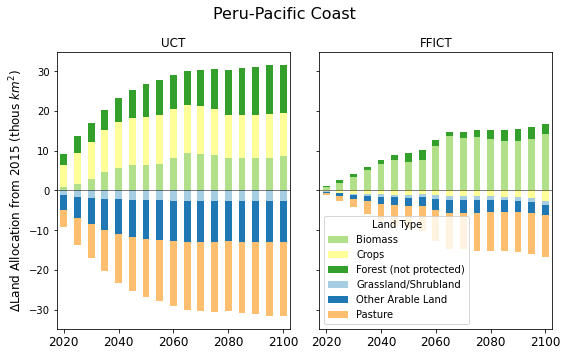

In [16]:
ppc_tax_lalloc = pd.read_pickle(fpath+'perupacificcoast_tax_lalloc')
ppc_uct, ppc_ffict = plot_landchange(ppc_tax_lalloc,'Peru-Pacific Coast') 

# Figures S8 - S11. Land Allocation for East Brazil-South Atlantic Coast and Mexico-Interior basins

### Figure S9. Land Allocation over time under UCT vs FFICT in East Brazil-South Atlantic Coast

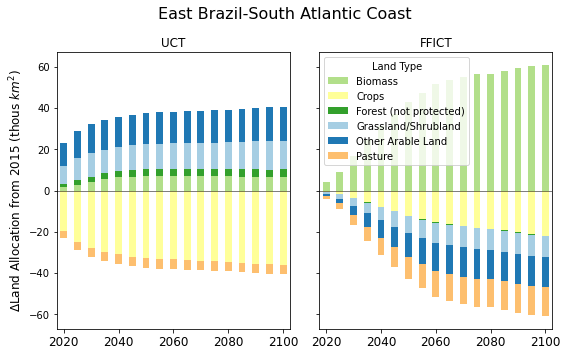

In [18]:
ebsac_lalloc_tax = pd.read_pickle(fpath+'ebsac_tax_lalloc')
ebsac_uct, ebsac_ffict = plot_landchange(ebsac_lalloc_tax,'East Brazil-South Atlantic Coast')

### Figure S10. Crop profit over time in East Brazil-South Atlantic Coast under UCT vs FFICT

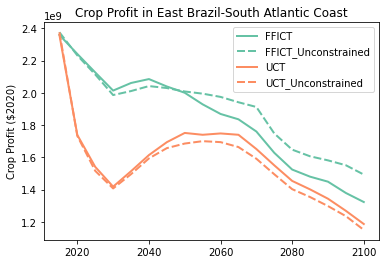

In [19]:
# Supplemental Figure 10: Ag profit in East Brazil-South Atlantic Coast basin
ebsac_crop_profit = pd.read_pickle(fpath+'ebsac_agprofit')

#convert from $1975 to $2020
cf = 3.81
ebsac_crop_profit['value_profit'] = ebsac_crop_profit['value_profit']*cf

#group across extra columns
ebsac_crop_profit = ebsac_crop_profit.groupby(['scenario','scen_or_unc','year','basin','crop'])['value_profit'].sum()
ebsac_crop_profit = ebsac_crop_profit.reset_index()

ebsac_crop_profit_sum = ebsac_crop_profit.groupby(['scenario','scen_or_unc','year','basin'])['value_profit'].sum()
ebsac_crop_profit_sum = ebsac_crop_profit_sum.reset_index()


sns.lineplot(data=ebsac_crop_profit_sum,x='year',y='value_profit',hue='scenario',palette='Set2',lw=2,style='scen_or_unc',
            style_order=['Scenario','Unconstrained'],hue_order=['FFICT','UCT'])
plt.xlabel('')
plt.ylabel('Crop Profit ($2020)')
plt.title('Crop Profit in East Brazil-South Atlantic Coast')
plt.legend(['FFICT','FFICT_Unconstrained','UCT','UCT_Unconstrained'])
plt.show()


### Figure S11. Land Allocation over time under UCT vs FFICT in Mexico-Interior

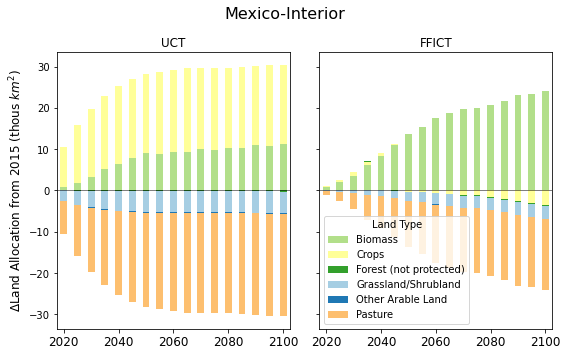

In [20]:
mexint_lalloc_tax = pd.read_pickle(fpath+'mexint_tax_lalloc')
mexint_uct, mexint_ffict = plot_landchange(mexint_lalloc_tax,'Mexico-Interior')

### Figure S8. Land allocation in 2015 in East Brazil-South Atlantic Coast and Mexico-Interior basins

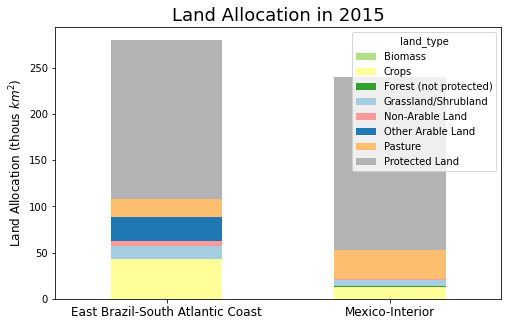

In [31]:
#pick a scenario and plot land allocation in the two basins in 2100 for that scenario
#scenario = 'ssp_socio5_ag1_gwlo_rs_hadgem_NDC_Tax_uct'
mexint_2100 = mexint_uct[mexint_uct.year==2015]
ebsac_2100 = ebsac_uct[ebsac_uct.year==2015]

#merge
ebsac_mexint_2100 = pd.concat([mexint_2100,ebsac_2100])

#filter
ebsac_mexint_2100 = pd.pivot_table(ebsac_mexint_2100,values='value',index='basin',columns='land_type')

#plot land allocation
c_list = {'Crops':'#ffff99',
          'Biomass':'#b2df8a',
                'Forest (not protected)':'#33a02c',
               'Non-Arable Land':'#fb9a99',
               'Grassland/Shrubland':'#a6cee3',
               'Pasture':'#fdbf6f',
             'Other Arable Land':'#1f78b4',
         'Protected Land':'#b3b3b3'}
fig,ax1 = plt.subplots(1,1,figsize=(8,5),)
ebsac_mexint_2100.plot.bar(ax=ax1,y=ebsac_mexint_2100.columns,stacked=True,color=c_list,legend=True)
ax1.set_title('Land Allocation in 2015',fontsize=18)
ax1.set_ylabel('Land Allocation (thous $km^2$)',fontsize=12)
ax1.set_xlabel('')
ax1.set_xticklabels(['East Brazil-South Atlantic Coast','Mexico-Interior'],rotation=0,fontsize=12)
plt.show()

# Figure S12. Crop Production in East Brazil-South Atlantic Coast and Mexico-Interior (by ESM)

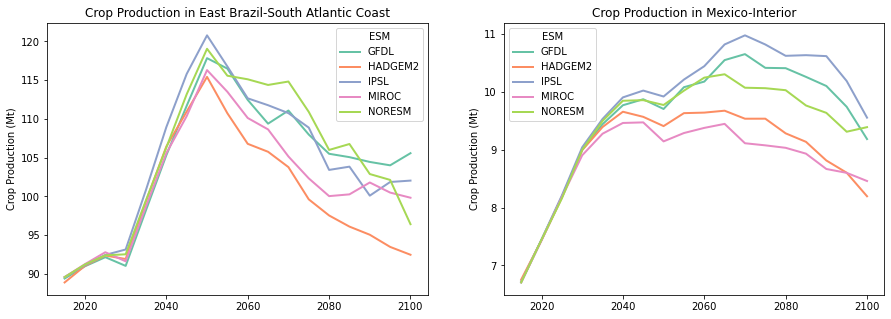

In [22]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

ebsac_agprod_esm = pd.read_pickle(fpath+'ebsac_esm_agprod')

#sum across technologies
ebsac_agprod_esm_sum = ebsac_agprod_esm.groupby(['Units','sector','output','year','esm'])['value'].sum()
ebsac_agprod_esm_sum = ebsac_agprod_esm_sum.reset_index()

#sum up across sectors - exclude biomass, forest, and pasture
ebsac_agprod_esm_sum = ebsac_agprod_esm_sum[~(ebsac_agprod_esm_sum['sector'].isin(['biomass','Pasture','Forest']))]
ebsac_agprod_esm_sum = ebsac_agprod_esm_sum.groupby(['Units','year','esm'])['value'].sum()
ebsac_agprod_esm_sum = ebsac_agprod_esm_sum.reset_index()

#plot production
sns.lineplot(ax=ax1,data=ebsac_agprod_esm_sum[ebsac_agprod_esm_sum.year>=2015],x='year',
             y='value',hue='esm',lw=2,palette='Set2')
ax1.set_xlabel('')
ax1.set_ylabel('Crop Production ('+ebsac_agprod_esm_sum['Units'].iloc[0]+')')
ax1.set_title('Crop Production in East Brazil-South Atlantic Coast')
ax1.legend(title='ESM',labels=['GFDL','HADGEM2','IPSL','MIROC','NORESM'])

mexint_agprod_esm = pd.read_pickle(fpath+'mexint_esm_agprod')

#sum across technologies
mexint_agprod_esm_sum = mexint_agprod_esm.groupby(['Units','sector','output','year','esm'])['value'].sum()
mexint_agprod_esm_sum = mexint_agprod_esm_sum.reset_index()

#sum up across sectors - exclude biomass, forest, and pasture
mexint_agprod_esm_sum = mexint_agprod_esm_sum[~(mexint_agprod_esm_sum['sector'].isin(['biomass','Pasture','Forest']))]
mexint_agprod_esm_sum = mexint_agprod_esm_sum.groupby(['Units','year','esm'])['value'].sum()
mexint_agprod_esm_sum = mexint_agprod_esm_sum.reset_index()

#plot production
sns.lineplot(ax=ax2,data=mexint_agprod_esm_sum[mexint_agprod_esm_sum.year>=2015],x='year',y='value',hue='esm',lw=2,palette='Set2')
ax2.set_xlabel('')
ax2.set_ylabel('Crop Production ('+mexint_agprod_esm_sum['Units'].iloc[0]+')')
ax2.set_title('Crop Production in Mexico-Interior')
ax2.legend(title='ESM',labels=['GFDL','HADGEM2','IPSL','MIROC','NORESM'])
plt.show()



# Figure S13. Biomass tech yields in East Brazil-South Atlantic Coast and Mexico-Interior in 2100 (by ESM)

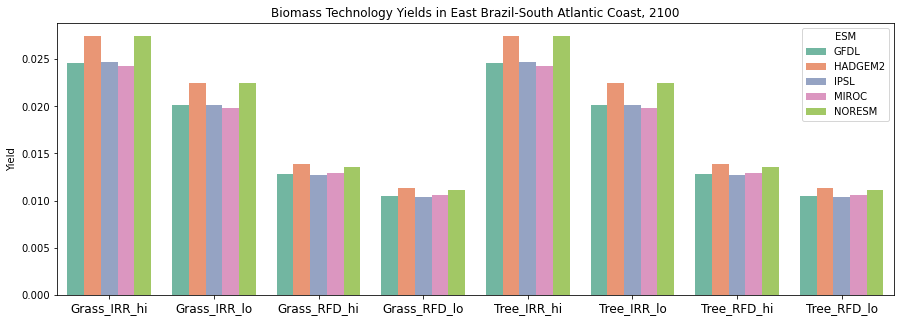

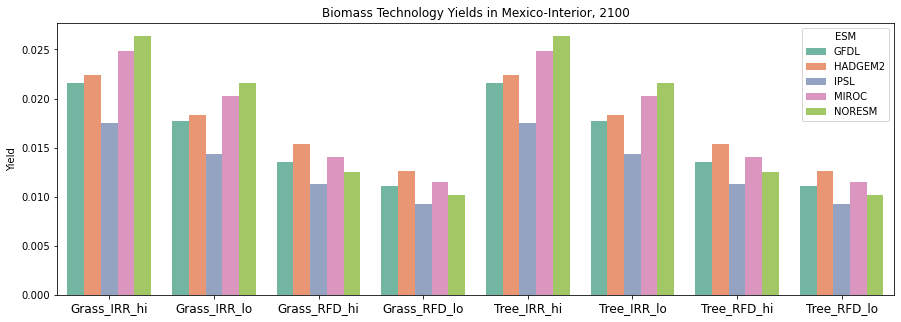

In [23]:
bmass_yield_ebsac = pd.read_pickle(fpath+'ebsac_bmass_yield')

fig,ax1 = plt.subplots(1,1,figsize=(15,5))
sns.barplot(ax=ax1,data=bmass_yield_ebsac,x='technology',y='value',hue='esm',palette='Set2',
            order = ['biomass_grass_BrzCstE_IRR_hi','biomass_grass_BrzCstE_IRR_lo',
         'biomass_grass_BrzCstE_RFD_hi' ,'biomass_grass_BrzCstE_RFD_lo',
         'biomass_tree_BrzCstE_IRR_hi', 'biomass_tree_BrzCstE_IRR_lo',
         'biomass_tree_BrzCstE_RFD_hi' ,'biomass_tree_BrzCstE_RFD_lo']
           )
ax1.set_title('Biomass Technology Yields in East Brazil-South Atlantic Coast, 2100')
ax1.set_ylabel('Yield')
ax1.set_xlabel('')
ax1.set_xticklabels(['Grass_IRR_hi','Grass_IRR_lo','Grass_RFD_hi','Grass_RFD_lo',
                    'Tree_IRR_hi','Tree_IRR_lo','Tree_RFD_hi','Tree_RFD_lo'],rotation=0,fontsize=12)
ax1.legend(title='ESM')
plt.show()

bmass_yield_mexint = pd.read_pickle(fpath+'mexint_bmass_yield')


fig,ax1 = plt.subplots(1,1,figsize=(15,5))
sns.barplot(ax=ax1,data=bmass_yield_mexint,x='technology',y='value',hue='esm',palette='Set2',
            order = ['biomass_grass_MexInt_IRR_hi','biomass_grass_MexInt_IRR_lo',
         'biomass_grass_MexInt_RFD_hi' ,'biomass_grass_MexInt_RFD_lo',
         'biomass_tree_MexInt_IRR_hi', 'biomass_tree_MexInt_IRR_lo',
         'biomass_tree_MexInt_RFD_hi' ,'biomass_tree_MexInt_RFD_lo']
           )
ax1.set_title('Biomass Technology Yields in Mexico-Interior, 2100')
ax1.set_ylabel('Yield')
ax1.set_xlabel('')
ax1.set_xticklabels(['Grass_IRR_hi','Grass_IRR_lo','Grass_RFD_hi','Grass_RFD_lo',
                    'Tree_IRR_hi','Tree_IRR_lo','Tree_RFD_hi','Tree_RFD_lo'],rotation=0,fontsize=12)
ax1.legend(title='ESM')
plt.show()

# Figure S14. Crop production in East Brazil-South Atlantic Coast and Mexico-Interior basins (by SOC)

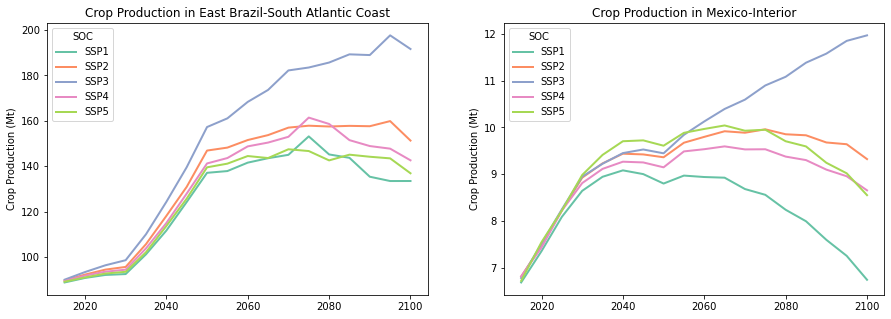

In [24]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

ebsac_agprod_soc = pd.read_pickle(fpath+'ebsac_soc_agprod')

#sum across technologies
ebsac_agprod_soc_sum = ebsac_agprod_soc.groupby(['Units','sector','output','year','soc'])['value'].sum()
ebsac_agprod_soc_sum = ebsac_agprod_soc_sum.reset_index()

#sum up across sectors - exclude biomass, forest, and pasture
ebsac_agprod_soc_sum = ebsac_agprod_soc_sum[~(ebsac_agprod_soc_sum['sector'].isin(['biomass','Pasture','Forest']))]
ebsac_agprod_soc_sum = ebsac_agprod_soc_sum.groupby(['Units','year','soc'])['value'].sum()
ebsac_agprod_soc_sum = ebsac_agprod_soc_sum.reset_index()

#plot production
sns.lineplot(ax=ax1,data=ebsac_agprod_soc_sum[ebsac_agprod_soc_sum.year>=2015],x='year',y='value',hue='soc',lw=2,palette='Set2')
ax1.set_xlabel('')
ax1.set_ylabel('Crop Production ('+ebsac_agprod_soc_sum['Units'].iloc[0]+')')
ax1.set_title('Crop Production in East Brazil-South Atlantic Coast')
ax1.legend(title='SOC',labels=['SSP1','SSP2','SSP3','SSP4','SSP5'])


mexint_agprod_soc = pd.read_pickle(fpath+'mexint_soc_agprod')

#sum across technologies
mexint_agprod_soc_sum = mexint_agprod_soc.groupby(['Units','sector','output','year','soc'])['value'].sum()
mexint_agprod_soc_sum = mexint_agprod_soc_sum.reset_index()

#sum up across sectors - exclude biomass, forest, and pasture
mexint_agprod_soc_sum = mexint_agprod_soc_sum[~(mexint_agprod_soc_sum['sector'].isin(['biomass','Pasture','Forest']))]
mexint_agprod_soc_sum = mexint_agprod_soc_sum.groupby(['Units','year','soc'])['value'].sum()
mexint_agprod_soc_sum = mexint_agprod_soc_sum.reset_index()

#plot production
sns.lineplot(ax=ax2,data=mexint_agprod_soc_sum[mexint_agprod_soc_sum.year>=2015],x='year',y='value',hue='soc',lw=2,palette='Set2')
ax2.set_xlabel('')
ax2.set_ylabel('Crop Production ('+mexint_agprod_soc_sum['Units'].iloc[0]+')')
ax2.set_title('Crop Production in Mexico-Interior')
ax2.legend(title='SOC',labels=['SSP1','SSP2','SSP3','SSP4','SSP5'])

plt.show()


# Figure S15. Crop profit in Rio Grande (by TAX)

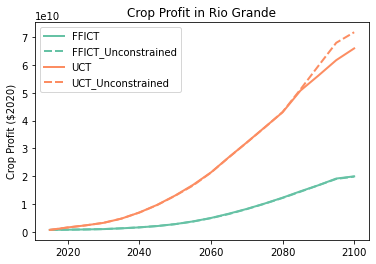

In [25]:
# Rio Grande Tax profit

riogrande_tax_profit = pd.read_pickle(fpath+'riogrande_tax_profit')
cf = 3.81
riogrande_tax_profit['value_profit'] = riogrande_tax_profit['value_profit']*cf #convert to $2020

#group across extra columns
riogrande_tax_profit = riogrande_tax_profit.groupby(['scenario','scen_or_unc','year','basin','crop'])['value_profit'].sum()
riogrande_tax_profit = riogrande_tax_profit.reset_index()

riogrande_tax_profit_sum = riogrande_tax_profit.groupby(['scenario','scen_or_unc','year','basin'])['value_profit'].sum()
riogrande_tax_profit_sum = riogrande_tax_profit_sum.reset_index()


sns.lineplot(data=riogrande_tax_profit_sum,x='year',y='value_profit',hue='scenario',palette='Set2',lw=2,style='scen_or_unc',
            style_order=['Scenario','Unconstrained'],hue_order=['FFICT','UCT'])
plt.xlabel('')
plt.ylabel('Crop Profit ($2020)')
plt.title('Crop Profit in Rio Grande')
plt.legend(['FFICT','FFICT_Unconstrained','UCT','UCT_Unconstrained'])
plt.show()
